## Face Recognition Using Principal Component Analysis (PCA)

****

### Name:

Hengyi Liu

****

## Dependencies

This notebook requires the following Python packages:

- numpy
- pandas
- matplotlib
- scikit-learn

Install them with:

```bash
pip install -r requirements.txt
```

****

## Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as kmeans
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

****

### Latent Face Indexing and Expression Retrieval.

The provided dataframe (**fdf**) is a $2n \times m$ matrix of face data, where the columns represent shape vectors (e.g., ${\bf f}_i$ is the column vector that represents the i<sup>th</sup> face in the dataset), and the rows represent landmarks on a $2$D human face (<a href="https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/">data reference</a>). Specifically, the $2n$-dimension column vector ${\bf f}_1=(x_0,y_0,x_1,y_1, \ldots, x_i, y_i, \ldots, x_{n-1}, y_{n-1})$ defines $n=68$ landmark locations on face $1$ (column named **f1**) in the dataset.

In general, the concepts from the latent semantic indexing paper (see the reference below) are applied to the face data. Specifically, low-dimensional latent relationships will be uncovered in the $2n \times m$ **landmark-face** matrix (instead of the term-document matrix) using singular value decomposition (SVD). Then, we will use these relationships to retrieve faces with similar **expressions** that are learned in the lower-dimensional latent space.

**Tips**:
- The latent semantic indexing <a href="https://drive.google.com/file/d/1dNB-fc-gaEGSauNTQyxlwWl9r2eZx8Fz/view?usp=drive_link">paper</a> that was published in 1990.

****

In [2]:
fdf = pd.read_csv("./data/facial_landmarks.csv" )
fdf

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187
0,-1.000000,-1.000000,-1.000000,-1.000000,-0.951937,-0.996250,-0.962643,-0.973699,-1.000000,-1.000000,...,-0.928993,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.950060,-0.914484,-1.000000,-1.000000
1,1.000000,0.832926,0.579261,0.231897,0.565381,0.849546,0.858178,0.817682,0.729727,0.467076,...,0.648711,0.724321,0.421352,0.711271,0.694059,0.490634,0.536417,-0.350551,0.507698,0.192629
2,-0.965634,-0.970360,-0.983060,-0.952045,-1.000000,-1.000000,-1.000000,-1.000000,-0.987371,-0.920799,...,-0.980922,-0.935998,-0.910346,-0.930497,-0.987213,-0.931974,-0.970648,-0.827805,-0.919498,-0.948147
3,0.685826,0.487520,0.318358,0.015101,0.318405,0.520962,0.511738,0.573777,0.457303,0.144798,...,0.468704,0.472606,0.179666,0.394879,0.403099,0.196641,0.289123,-0.509708,0.248383,-0.064326
4,-0.950751,-0.838847,-0.969005,-0.868485,-0.998650,-0.950642,-0.973317,-0.983797,-0.953697,-0.823358,...,-1.000000,-0.876227,-0.880468,-0.920069,-0.965791,-0.841766,-0.925714,-0.758012,-0.846001,-0.902248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-0.626924,-0.361757,-0.318876,-0.502801,-0.363823,-0.371101,-0.203414,-0.346591,-0.456504,-0.341847,...,-0.386944,-0.500128,-0.446003,-0.425400,-0.380385,-0.503704,-0.585163,-0.215784,-0.312186,-0.374595
132,0.107520,0.113745,-0.153760,0.375983,-0.400380,0.043260,0.289086,0.090587,-0.157003,0.419915,...,-0.386670,0.402114,0.220366,0.389456,-0.008135,0.521426,-0.202704,-0.024853,0.553613,0.464788
133,-0.657572,-0.404557,-0.350701,-0.541314,-0.374537,-0.380429,-0.226528,-0.379223,-0.459393,-0.354035,...,-0.380905,-0.533512,-0.437627,-0.407400,-0.384911,-0.576235,-0.591528,-0.292822,-0.317218,-0.390096
134,0.013293,0.001258,-0.270076,0.253130,-0.501222,-0.075586,0.177918,-0.020670,-0.264473,0.290111,...,-0.489210,0.263180,0.075984,0.263974,-0.097492,0.399933,-0.287718,-0.116465,0.453454,0.403976


****

**P1** (10 Points): Latent face spaces.

<img src="./images/p1_solution.png" width="600" style="float: right"/>

Using the **fdf** dataframe, first randomly shuffle the columns (i.e., faces) and then split the shuffled data into training and testing matrices. The split is very simple. The shuffled training matrix will contain 185 faces from the first 185 columns (0 to 184), and the shuffled testing matrix will contain 3 faces from the last 3 columns (185 to 187).

The singular value decomposition (SVD) unsupervised learning method will be applied to the training matrix, and three low-dimensional latent spaces (using the data in the right singular vector matrix $V$) will be generated and visualized. Specifically,
- **A PC1 and PC2 latent space**. This space includes data represented by the first and second columns of $V$ (i.e., the columns associated with the largest and second-largest singular values).
- **A PC2 and PC3 latent space**. This space includes the data represented by the second and third columns in $V$ (i.e., the columns associated with the second and third-largest singular values).
- **A PC3 and PC4 latent space**. This space includes data represented by the third and fourth columns in $V$ (i.e., the columns associated with the third and fourth-largest singular values).

To receive full credit, your solution should produce plots similar to the reference plots. 

**Notes**:
- Only the training data is used to generate the scatter plots.
- You must use singular value decomposition (SVD).
- You may use the SVD function (<a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html">reference</a>) included in the NumPy library.
- The **svd** NumPy function will sort the singular value matrix ($S$) and its corresponding right ($V$) and left ($U$) singular vector matrices in descending order.
- Don't forget to undo the right singular vector matrix ($V$) transpose after SVD is performed.
- Your plots won't be identical because the training data is a random shuffling of the dataframe.
- If you have questions or are unsure, you must ask.

**Plot assumptions**:
- The plot figure size is **15** inches in width and **5** inches in height.
- The plots must be placed in a $1 \times 3$ grid pattern (see reference plots).
- The color used to generate the plot is ``dimgray``.
- The label font size is $11$.
- The marker shape is **o**.
- The marker size is $50$.
- The marker alpha (opacity) value is set to $0.5$.
- The plot uses a tight layout (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html">reference</a>).


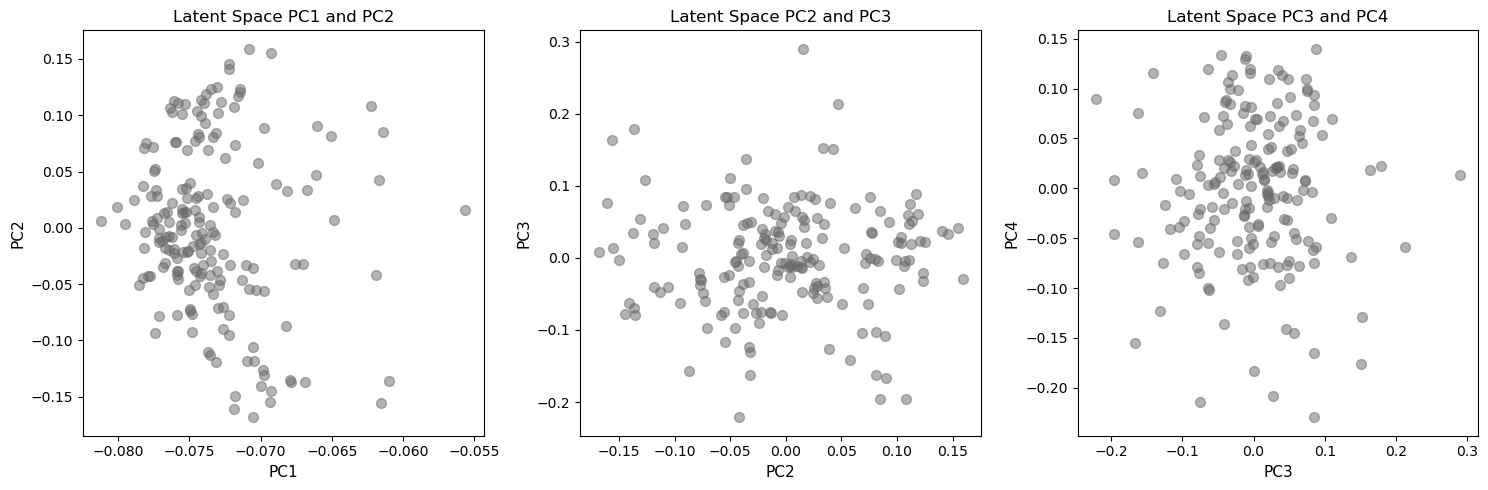

In [3]:
# --------------------------------------
# Add your P1 coding solution below.
# --------------------------------------

# Shuffle columns and perform train-test split
fdf_shuffled = fdf.sample(frac=1, axis=1)
X_train = fdf_shuffled.iloc[:, :185].to_numpy()
X_test = fdf_shuffled.iloc[:, 185:].to_numpy()

# Apply SVD to X_train and extract principal components
T, S, VT = np.linalg.svd(X_train, full_matrices=False)
S = np.eye( S.shape[0] ) * S
V = VT.T
PC1, PC2, PC3, PC4 = V[:, 0], V[:, 1], V[:, 2], V[:, 3]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
axs[0].scatter(x=PC1, y=PC2, c='dimgray', marker='o', s=50, alpha=0.5)
axs[0].set_title('Latent Space PC1 and PC2')
axs[0].set_xlabel('PC1', fontsize=11)
axs[0].set_ylabel('PC2', fontsize=11)

# Plot 2
axs[1].scatter(x=PC2, y=PC3, c='dimgray', marker='o', s=50, alpha=0.5)
axs[1].set_title('Latent Space PC2 and PC3')
axs[1].set_xlabel('PC2', fontsize=11)
axs[1].set_ylabel('PC3', fontsize=11)

# Plot 3
axs[2].scatter(x=PC3, y=PC4, c='dimgray', marker='o', s=50, alpha=0.5)
axs[2].set_title('Latent Space PC3 and PC4')
axs[2].set_xlabel('PC3', fontsize=11)
axs[2].set_ylabel('PC4', fontsize=11)

plt.tight_layout()
plt.show()


****

**P2** (10 Points): Learning facial expressions.

<img src="./images/p2_solution.png" width="600" style="float: right"/>

Using the data generated in **P1**,the k-means unsupervised learning method is used to learn three facial expressions in each low-dimensional latent space, as shown in the reference plots.

Specifically, in each latent space: 
- The k-means method will identify **three** facial expression clusters, represented by blue, red, and green colors (the **\*** marker indicates the cluster centroid).
- For each facial expression cluster, facial expression plots are generated by averaging landmark points.

To receive full credit, your solution should produce plots similar to the reference plots. 

**Notes**:
- A row in the right singular vector matrix $V$ corresponds to a column in the training data (i.e., they represent the same face).
- You may use the k-means function (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">reference</a>) included in the Sklearn library (see Python modules above).
- The **n_clusters** and **n_init** k-means parameters are $3$ and $10$, respectively (all others are the default value).
- Your plots won't be identical because the training data is a random shuffling of the dataframe (see P1).
- If you have questions or are unsure, you must ask.

**Plot assumptions**:
- The plot figure size is **15** inches in width and **15** inches in height.
- The plots must be placed in a $3 \times 4$ grid pattern (see reference plots).
- The color used to generate the plots is ``blue``, ``red``, and ``green``.
- The default x-axis and y-axis tick values are removed (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html">reference</a>).
- For marker shape **o** in the latent plot, the size is $50$ and the alpha (opacity) is $0.15$.
- For marker shape **\*** in the latent plot, the size is $150$.
- For marker shape **o** in the expression plots, the size is $50$.
- The plot axis is ``equal`` in the expression plots.
- The plot uses a tight layout (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html">reference</a>).


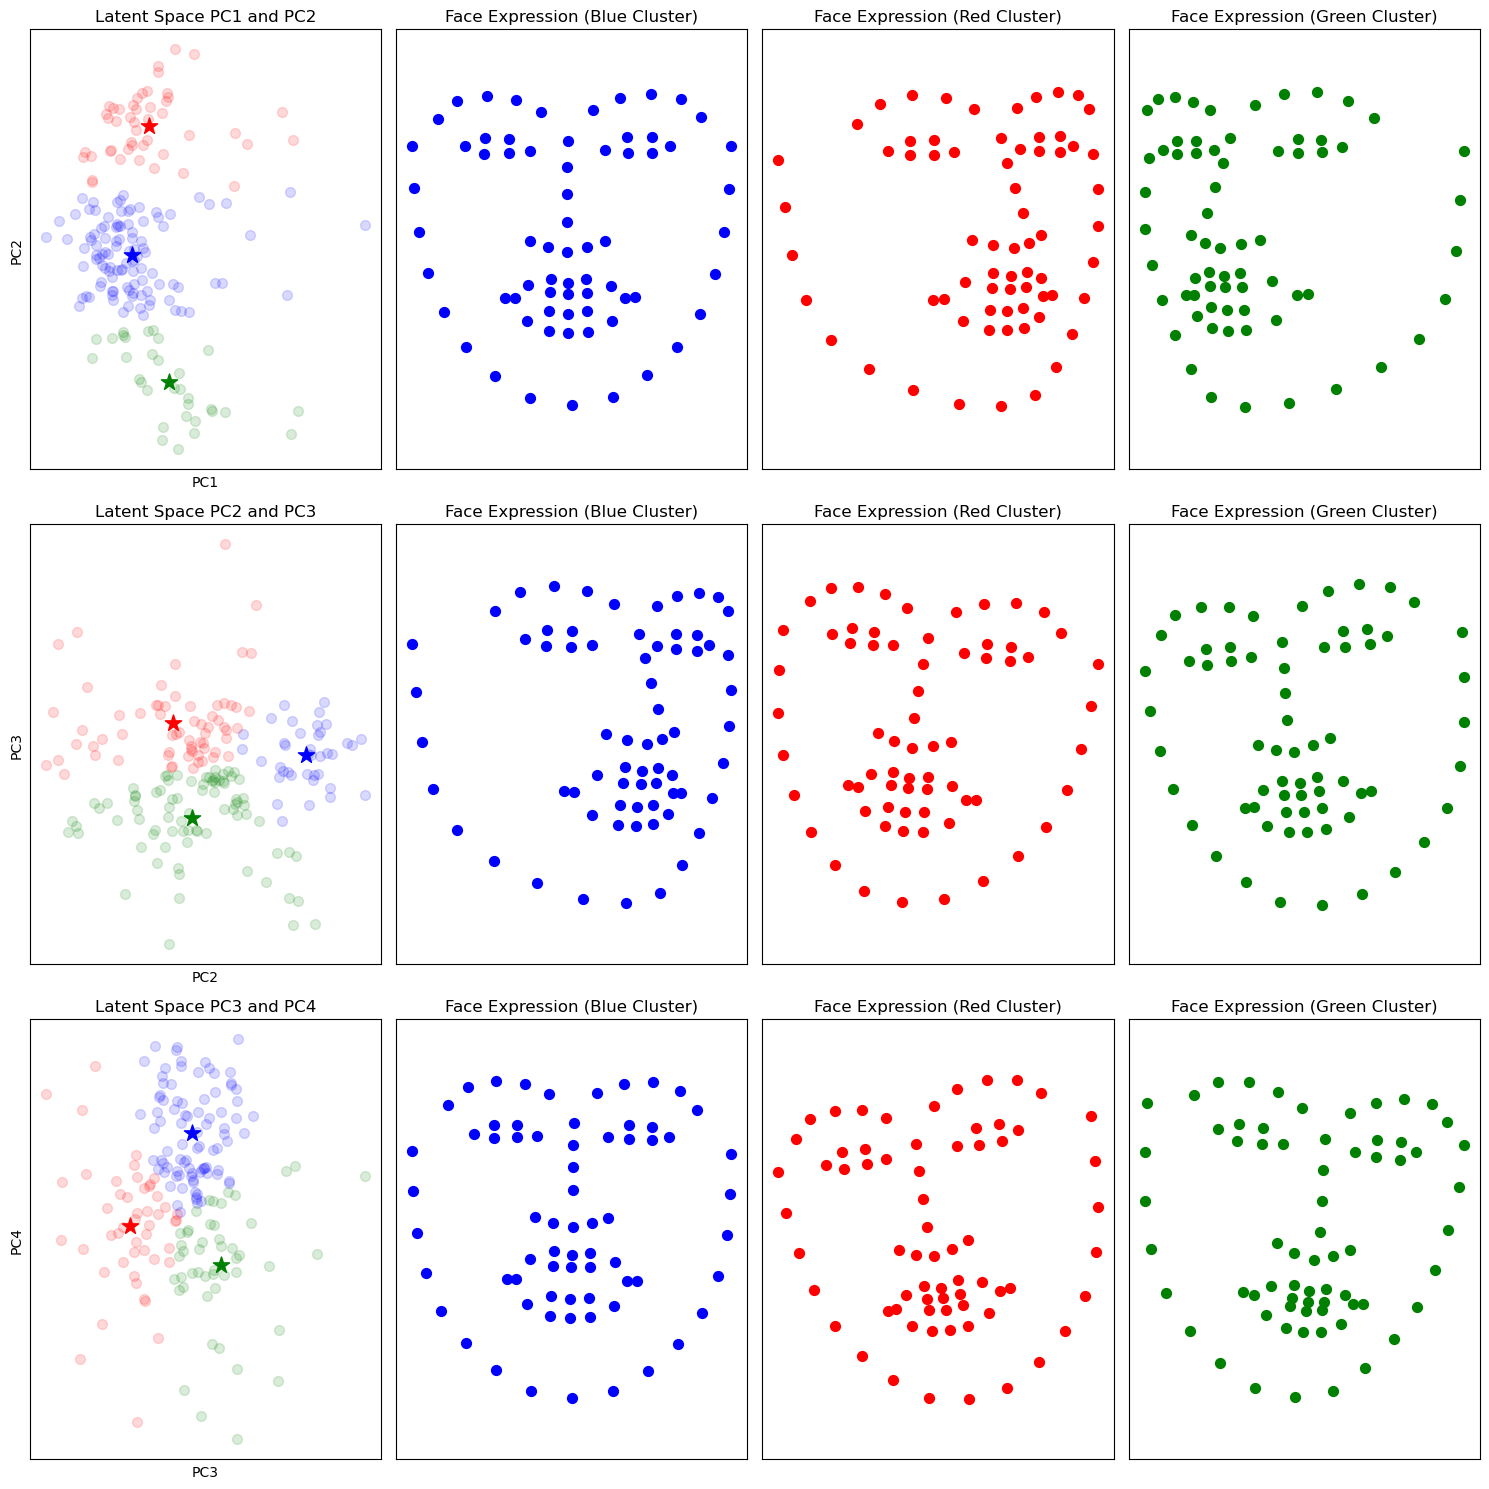

In [4]:
# --------------------------------------
# Add your P2 coding solution below.
# --------------------------------------

k = 3
p2_kmeans = kmeans(n_clusters=k, n_init=10)
colors = ['blue', 'red', 'green']
plots_centroids = []
plots_mean_faces = []

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for row in range(3):
    # Perform k-means
    X = V[:, row:row+2]
    p2_kmeans.fit(X)

    # Plot latent plot
    axis = axes[row, 0]
    centroids = []
    for label in range(k):
        # Plot cluster points
        cluster_points = X[p2_kmeans.labels_ == label, :]
        axis.scatter(cluster_points[:, 0], cluster_points[:, 1], marker='o', s=50, c=colors[label], alpha=0.15)
        # Plot centroid
        centroid = p2_kmeans.cluster_centers_[label]
        centroids.append(centroid)
        axis.scatter(centroid[0], centroid[1], marker='*', s=150, c=colors[label])
    plots_centroids.append(centroids)
    axis.set_title(f'Latent Space PC{row+1} and PC{row+2}')
    axis.set_xlabel(f'PC{row+1}')
    axis.set_ylabel(f'PC{row+2}')
    axis.set_xticks([])
    axis.set_yticks([])

    # Plot expression plots
    mean_faces = []
    for label in range(k):
        # Calculate mean face
        cluster_rows = V[p2_kmeans.labels_ == label, :]
        mean_row = np.mean(cluster_rows, axis=0)
        mean_face = T @ S @ mean_row.T
        mean_faces.append(mean_face)

        # Plot mean face
        axis = axes[row, label+1]
        axis.scatter(x=mean_face[::2], y=mean_face[1::2], marker='o', s=50, color=colors[label])
        axis.set_title(f'Face Expression ({colors[label].title()} Cluster)')
        axis.set_xticks([])
        axis.set_yticks([])
        axis.axis('equal')
    plots_mean_faces.append(mean_faces)

plt.tight_layout()
plt.show()


****

**P3** (10 Points): Facial expression retrieval.

<img src="./images/p3_solution.png" width="600" style="float: right"/>

Using the facial expression clusters learned in **P2**, for each query face in the testing dataset, the matching facial expression is retrieved from each low-dimensional latent space. Specifically, first, the query face is projected into the latent space, then the L2 distance to each cluster center is calculated, and the facial expression corresponding to the nearest cluster is retrieved.

To receive full credit, your solution should produce plots similar to the reference plots. 

**Notes**:
- Projecting a query vector into the low-dimension latent space is outlined in the LSI paper. (see Tips).
- Manually compute the L2 (Euclidean) distance (i.e., **do not** use any numpy function).
- Your plots won't be identical because the testing and training data are a random shuffling of the dataframe (see P1).
- If you have questions or are unsure, you must ask.

**Plot assumptions**:
- The plot figure size is **12** inches in width and **12** inches in height.
- The plots must be placed in a $3 \times 4$ grid pattern (see reference plots).
- The color used to generate the retrieved plots is ``blue``, ``red``, and ``green``.
- The color used to generate the query plot is ``black``.
- The default x-axis and y-axis tick values are removed (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html">reference</a>).
- The marker shape is **o** and the marker size is $15$.
- The plot axis is ``equal``.
- The plot uses a tight layout (<a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html">reference</a>).


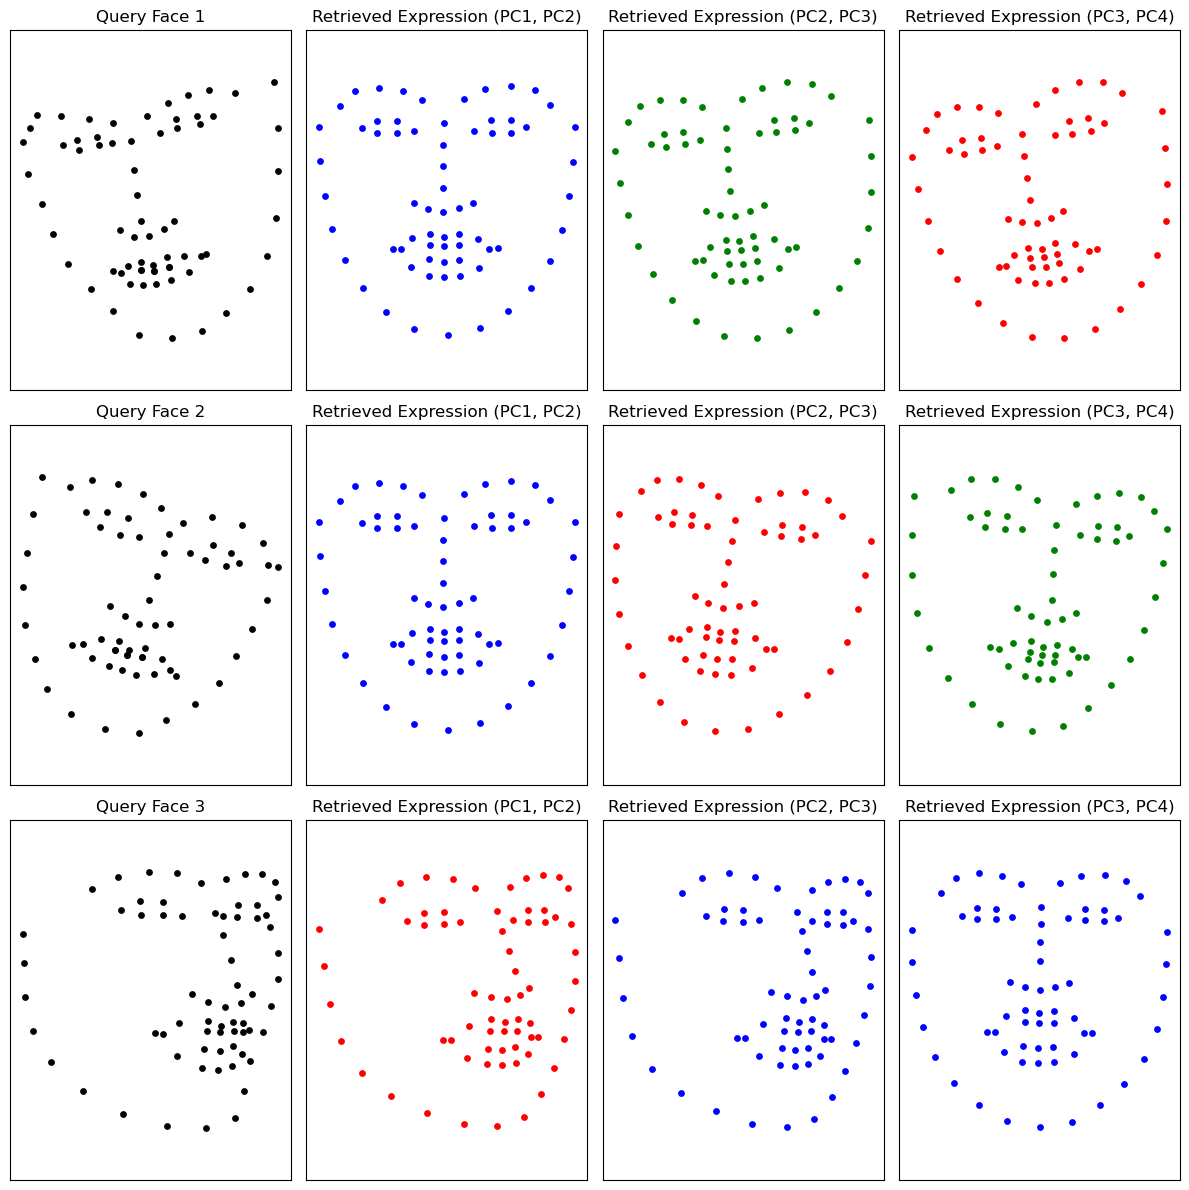

In [5]:
# --------------------------------------
# Add your P3 coding solution below.
# --------------------------------------

def compute_l2_distance(a, b):
    return np.sqrt(np.sum(np.square(b - a)))

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for row in range(X_test.shape[1]):
    # Plot query face
    query_face = X_test[:, row]
    axis = axes[row, 0]
    axis.scatter(x=query_face[::2], y=query_face[1::2], color='black', marker='o', s=15)
    axis.set_title(f'Query Face {row+1}')
    axis.set_xticks([])
    axis.set_yticks([])
    axis.axis('equal')

    for col in range(3):
        # Project query face into latent space
        T_query = T[:, col:col+2]
        S_inv_query = np.linalg.inv(S[col:col+2, col:col+2])
        query_projection = query_face @ T_query @ S_inv_query
        # Compute nearest cluster
        min_distance = np.inf
        nearest_cluster = None
        for cluster in range(k):
            distance = compute_l2_distance(query_projection, plots_centroids[col][cluster])
            if distance < min_distance:
                min_distance = distance
                nearest_cluster = cluster
        if nearest_cluster is None:
            raise ValueError("Nearest cluster was not found.")
        # Retrieve facial expression
        retrieved_face = plots_mean_faces[col][nearest_cluster]

        # Plot retrieved expression
        axis = axes[row, col+1]
        axis.scatter(x=retrieved_face[::2], y=retrieved_face[1::2], marker='o', s=15, color=colors[nearest_cluster])
        axis.set_title(f'Retrieved Expression (PC{col+1}, PC{col+2})')
        axis.set_xticks([])
        axis.set_yticks([])
        axis.axis('equal')

plt.tight_layout()
plt.show()
